In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV

In [2]:
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv(r"C:\Users\91882\OneDrive\Desktop\spy.csv")
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index("Date").sort_index()

# Price Return 
data['PRet'] = data['Adj Close'].pct_change()

## feature Engineering

In [4]:
data = data.dropna()

### We define some features based on return characteristics and volume data. 

One can make an argument that such features are capturing mean reversion pattern or short term momemtum 
of the price returns.

Ideally, you can start from literature survey or even from extensive Exploratory data analysis on what feature space you want to start with.

Here, for starters I am starting with features which are motivated from technical indicators paramters like 2 day , 5 day , 14 day ... moving averages for indicators.


I will be using price returns and daily volume as my base features to arrive at new features.

__In an ideal world with thousands of years of SPYDER price series data, advance AI technquies will be able
to capture these features on its own__.


List of Price Based Features:

0. Target : Next Day Return

1. Previous Day Return (Pt-1)
2. Previous Day (Pt-2)
3. Previous Two Days Cumulative Return ( Pt-1+1) X (1+Pt-2)-1
4. Rolling previous 5 Day Cumulative Return (Pt-1+1)....X(Pt-6+1) - 1
5. Rolling previous 14 Day Cumulative Return (Pt-1+1)....X(Pt-15+1) - 1
6. Rolling previous 22 Day Cumulative Return (Pt-1+1)....X(Pt-22+1) - 1
7. Rolling previous 120 Day Cumulative Return (Pt-1+1)....X(Pt-121+1) - 1
8. Rolling previous 250 Day Cumulative Return (Pt-1+1)....X(Pt-251+1) - 1

Volume Features:

9.  Previous day volume 
10. Previous 2 Day  volume
11. Previous 5 day  volume
12. Previous 14 day volume
13. Previous 22 day volume
13. Previous 120 day volume

All these features are divided by rolling 250 Day volume. 

The idea is that we are trying to scale this volume on a comparable
level.

As can be viewed from the plot.




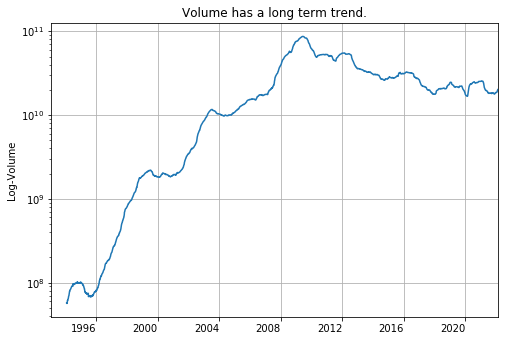

In [5]:
_ = (data.Volume.rolling(252).sum().plot(grid=True,logy=True,rot=0,figsize=(8,6))
.set(xlabel='',ylabel='Log-Volume',title='Volume has a long term trend.')
)

In [6]:
data['target'] = data['PRet']

 Coding Core Factors !!

In [7]:
def geo_ret(ser):
    return (1+ser).prod()-1

data['fac1'] = data['PRet'].shift(1) # Previous Day Return
data['fac2'] = data['PRet'].shift(2) # Previous Day -1 Return
data['fac3'] = (1+data['fac1'])*(1+data['fac2'])-1 # Previous Two Days Cumulative Returns

data['fac4'] = data['PRet'].rolling(5).apply(geo_ret).shift(1)
data['fac5'] = data['PRet'].rolling(14).apply(geo_ret).shift(1)
data['fac6'] = data['PRet'].rolling(22).apply(geo_ret).shift(1)
data['fac7'] = data['PRet'].rolling(120).apply(geo_ret).shift(1)
data['fac8'] = data['PRet'].rolling(250).apply(geo_ret).shift(1)

data['OneYearVolume'] = data['Volume'].rolling(250).sum().shift(1)

data['fac9']  = data['Volume'].shift(1)/data['OneYearVolume']
data['fac10'] = data['Volume'].rolling(2).sum().shift(1)/data['OneYearVolume']
data['fac11'] = data['Volume'].rolling(5).sum().shift(1)/data['OneYearVolume']
data['fac12'] = data['Volume'].rolling(14).sum().shift(1)/data['OneYearVolume']
data['fac13'] = data['Volume'].rolling(22).sum().shift(1)/data['OneYearVolume']
data['fac14'] = data['Volume'].rolling(120).sum().shift(1)/data['OneYearVolume']

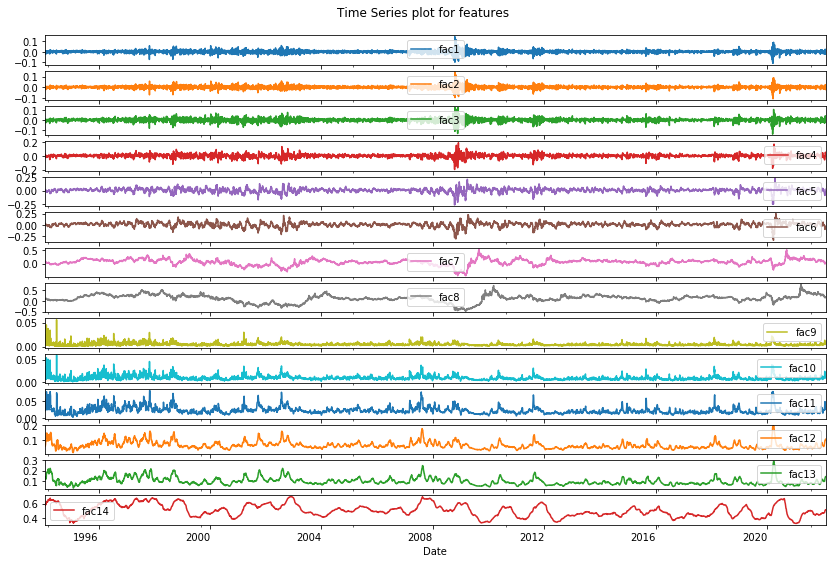

In [8]:
_ =  ( data
      .dropna()
      .filter(like='fac')
      .plot(subplots=True,legend=True,figsize=(14,10),rot=0,sharex=True)
     )
_ = plt.suptitle('Time Series plot for features',y=.92)

In [9]:
factors = data.dropna().filter(like='fac').columns.tolist()

In [10]:
print(data[factors]
      .corrwith(data['target'])
      .to_frame(name='Features correlation with target')
      .to_string())
## Why the features are negatively correlated??
## Is it indicating reversal? Yes and No !

       Features correlation with target
fac1                          -0.088553
fac2                          -0.020331
fac3                          -0.078503
fac4                          -0.075834
fac5                          -0.042904
fac6                          -0.048546
fac7                          -0.012836
fac8                          -0.005575
fac9                           0.027748
fac10                          0.018918
fac11                          0.020017
fac12                          0.013146
fac13                          0.018644
fac14                          0.008097


In [11]:
# Lets split data into train and test set!!
train = data.loc[:"2010"]
test  = data.loc["2011":] 

In [12]:
trainobs , testobs = len(train),len(test)

print(f"No of obs in train data set {trainobs}")
print(f"No of obs in test data set {testobs}")
print(f"Fraction of test size {(testobs/(testobs+trainobs)):.3f}")

No of obs in train data set 4515
No of obs in test data set 2798
Fraction of test size 0.383


__Ordinary Least Square Method!!__

This is the working horse method in quantitaive finance.

Y = intercept + beta(1) x Variable (1) + beta(2) x Variable (2) + .....
.... + beta(n) x Variable (n)

Y : target variable (Next Day Return)
X : features ( fac1, fac2, .... fac14)

In [13]:
train = train.dropna()
y = train['target'] # target
x = train.drop('target',axis=1)[factors] # features
x = sm.add_constant(x)

model_ols = sm.OLS(y,x).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     5.817
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           2.03e-11
Time:                        21:31:36   Log-Likelihood:                 12596.
No. Observations:                4265   AIC:                        -2.516e+04
Df Residuals:                    4250   BIC:                        -2.507e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.289      0.772      -0.003       0.002
fac1          -3.7843      0.716     -5.286      0.000      -5.188      -2.381
fac2          -3.8137      0.720     -5.294      0.000      -5.226      -2.401
fac3           3.7453      0.720      5.205      0.000       2.335       5.156
fac4          -0.0190      0.011     -1.702      0.089      -0.041       0.003
fac5           0.0075      0.009      0.857      0.392      -0.010       0.025
fac6          -0.0080      0.007     -1.164      0.245      -0.022       0.005
fac7           0.0031      0.003      1.148      0.251      -0.002       0.008
fac8          -0.0003      0.001     -0.223      0.823      -0.003       0.003
fac9           0.1078      0.129      0.839      0.402      -0.144       0.360
fac10         -0.0869      0.099     -0.877      0.380      -0.281       0.107
fac11          0.0427      0.048      0.898      0.369      -0.051       0.136
fac12         -0.0148      0.031     -0.483      0.629      -0.075       0.045
fac13          0.0111      0.019      0.579      0.563      -0.026       0.048
fac14         -0.0001      0.003     -0.034      0.973      -0.007       0.006
==============================================================================
Omnibus:                      679.492   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12493.113
Skew:                          -0.041   Prob(JB):                         0.00
Kurtosis:                      11.384   Cond. No.                     7.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## How to judge the performance of an ols method?

1. Adj R2 is the measure of fit. Higher the value better the model.
2. Tstats of factors should be high (subjective but greater than 3 is what 
adds the maximum value).
3. Conditional number should not be too large to cause and issue.
4. skewness number should be close to zero.
5. kurtosis should be close to three.

4,5 are proxy for error distribution is normal or not.
                       


In [14]:
def error_stats(df):
    return df.kurtosis()+3,df.skew()

kurt 11.395, skew 0.041


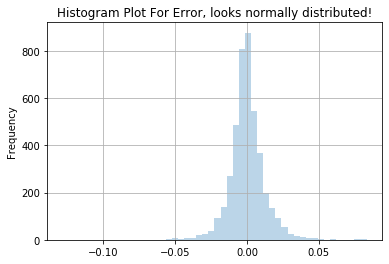

In [15]:
error = (model_ols.predict(x)-y)
_ = error.plot(kind='hist',bins=50,grid=True,alpha=.3).set(title='Histogram Plot For Error, looks normally distributed!')

kurt,skew = error_stats(error)  # But it is not!
print(f"kurt {kurt:.3f}, skew {skew:.3f}")

The real issue is very explainability of the model.

Just 1.06% explanatory power! That too INSAMPLE!

__How to think about Improvement!__

1. Kurtosis : It is hinting that there are outliers at extreme. This could be hinting at extreme or non linear relationship.

2. Lets try to introduce non-linearity in model by creating higher order features.


Trick is noticing that OLS is linear in betas not in variables. Variables can have higher order power.


A very simple way to do that is follows:

* from linear features such as  fac1 , fac2 ,fac3...
* we can get non linear interactions such as fac1 x fac2 , fac1 x fac3, fac1 x fac1, fac2 x fac2,fac2 x fac3.......

In [16]:
# lets use sklearn preprocessing tool to generate interaction features!
pf = PolynomialFeatures(degree=3)
Xp = pf.fit_transform(train.drop('target',axis=1)[factors])
factorsp = pf.get_feature_names(factors)
Xp = pd.DataFrame(Xp,columns=factorsp,index=train.index)
y = y
print(f"From a list of {len(factors)} features we have not got {len(factorsp)} features")

From a list of 14 features we have not got 680 features


In [17]:
model_2  = sm.OLS(y,Xp).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     3.322
Date:                Tue, 22 Feb 2022   Prob (F-statistic):          2.88e-115
Time:                        21:31:37   Log-Likelihood:                 13575.
No. Observations:                4265   AIC:                        -2.582e+04
Df Residuals:                    3600   BIC:                        -2.159e+04
Df Model:                         664                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
1                     0.1179      0.054      2.169      0.030       0.011       0.225
fac1               1.401e+05   3.07e+05      0.456      0.649   -4.63e+05    7.43e+05
fac2               1.401e+05   3.07e+05      0.456      0.649   -4.63e+05    7.43e+05
fac3              -1.401e+05   3.07e+05     -0.456      0.649   -7.43e+05    4.63e+05
fac4                 -0.2942      0.560     -0.525      0.600      -1.393       0.804
fac5                 -0.6926      0.448     -1.546      0.122      -1.571       0.186
fac6                  0.0821      0.381      0.216      0.829      -0.664       0.828
fac7                 -0.0552      0.188     -0.293      0.769      -0.424       0.314
fac8                 -0.0302      0.109     -0.278      0.781      -0.243       0.183
fac9                 -3.1906      8.004     -0.399      0.690     -18.884      12.503
fac10                 5.6154      5.898      0.952      0.341      -5.949      17.180
fac11                -2.6272      2.565     -1.024      0.306      -7.656       2.402
fac12                -3.0609      1.691     -1.810      0.070      -6.377       0.255
fac13                 3.1844      1.058      3.009      0.003       1.110       5.259
fac14                -0.8400      0.347     -2.418      0.016      -1.521      -0.159
fac1^2            -2.954e+05   6.07e+05     -0.486      0.627   -1.49e+06    8.95e+05
fac1 fac2         -4.203e+05   9.22e+05     -0.456      0.649   -2.23e+06    1.39e+06
fac1 fac3          1.268e+06   2.76e+06      0.459      0.647   -4.15e+06    6.69e+06
fac1 fac4         -1.824e+04   4.35e+04     -0.419      0.675   -1.04e+05     6.7e+04
fac1 fac5          5.375e+04    3.3e+04      1.626      0.104    -1.1e+04    1.19e+05
fac1 fac6         -8.422e+04   4.49e+04     -1.876      0.061   -1.72e+05    3786.867
fac1 fac7          1.289e+04   2.57e+04      0.501      0.616   -3.75e+04    6.33e+04
fac1 fac8         -1.301e+04    1.8e+04     -0.723      0.470   -4.83e+04    2.23e+04
fac1 fac9         -8.822e+04   1.08e+06     -0.082      0.935   -2.21e+06    2.03e+06
fac1 fac10          6.41e+05    8.7e+05      0.737      0.461   -1.06e+06    2.35e+06
fac1 fac11        -6.472e+05   3.31e+05     -1.957      0.050    -1.3e+06    1112.692
fac1 fac12        -1.215e+05   2.28e+05     -0.532      0.595   -5.69e+05    3.26e+05
fac1 fac13        -4168.1195   1.29e+05     -0.032      0.974   -2.58e+05    2.49e+05
fac1 fac14         3.907e+04   3.54e+04      1.105      0.269   -3.03e+04    1.08e+05
fac2^2            -2.651e+05   6.23e+05     -0.426      0.670   -1.49e+06    9.56e+05
fac2 fac3          1.237e+06   2.78e+06      0.445      0.656   -4.21e+06    6.69e+06
fac2 fac4         -1.825e+04   4.35e+04     -0.420      0.675   -1.04e+05     6.7e+04
fac2 fac5          5.375e+04    3.3e+04      1.626      0.104    -1.1e+04

__Is the drastic improvement in Adj-r2 justified?__

Well, the short answer is __NO__. 
And the culprit is overfitting.

This is what happens when you use SVM or RandomForest for smaller sample size like this.
Out sample performance is going to be terrible!


__Feature Selection__

We can rely on lasso based shrinkage method to eliminate features that are not adding any
additional information but are the cause of high collinearity problem.

LassoCV(
    eps=0.001,
    n_alphas=100,
    alphas=None,
    fit_intercept=True,
    normalize=False,
    precompute='auto',
    max_iter=1000,
    tol=0.0001,
    copy_X=True,
    cv=None,
    verbose=False,
    n_jobs=None,
    positive=False,
    random_state=None,
    selection='cyclic',
)


Features with non zero-coefficient from lasso are selected. 

In [18]:
def zscore(df):
    return (df-df.mean()).div(df.std())

In [19]:
Xp_norm = Xp.pipe(zscore).drop('1',axis=1)
y_norm = y.pipe(zscore)

In [20]:
mod = LassoCV(cv=20,n_jobs=4,fit_intercept=False).fit(Xp_norm,y_norm)

coefs =  pd.Series(mod.coef_,index=Xp_norm.columns.tolist())

print(coefs[coefs!=0]
      .abs()
      .sort_values(ascending=False)
      .to_frame(name='ABS Coeff')
      .to_string())

                 ABS Coeff
fac2 fac4 fac6    0.112746
fac2 fac4^2       0.082120
fac1^2 fac3       0.070955
fac4 fac5 fac8    0.050314
fac2^2 fac5       0.047274
fac2 fac5 fac6    0.043371
fac1 fac5 fac8    0.040618
fac1 fac3 fac14   0.028012
fac1 fac2^2       0.021878
fac1 fac9 fac14   0.021005
fac1 fac4 fac8    0.017078
fac1 fac9^2       0.010208
fac4^3            0.007996
fac2 fac10^2      0.006698
fac2^3            0.006422
fac1 fac2 fac7    0.004966
fac1^2 fac4       0.003806
fac11^2 fac12     0.003706
fac6 fac7^2       0.003455
fac4 fac8 fac9    0.001625


In [21]:
selected_features_a = coefs[coefs!=0].index.tolist()
Xs = Xp[selected_features_a]
Xs = sm.add_constant(Xs)

model1 = sm.OLS(y,Xs).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     20.12
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           2.24e-69
Time:                        21:32:15   Log-Likelihood:                 12749.
No. Observations:                4265   AIC:                        -2.546e+04
Df Residuals:                    4244   BIC:                        -2.532e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0001      0.000      0.446      0.655      -0.000       0.001
fac1^2 fac3       -30.9140      5.773     -5.355      0.000     -42.231     -19.597
fac1^2 fac4        -9.7437      8.187     -1.190      0.234     -25.795       6.307
fac1 fac2^2        86.2404     21.201      4.068      0.000      44.675     127.806
fac1 fac2 fac7     -4.0659      3.155     -1.289      0.198     -10.251       2.120
fac1 fac3 fac14     1.8029      0.848      2.127      0.033       0.141       3.465
fac1 fac4 fac8      1.8268      1.636      1.116      0.264      -1.381       5.035
fac1 fac5 fac8      2.7828      0.986      2.821      0.005       0.849       4.717
fac1 fac9^2        47.7967    307.688      0.155      0.877    -555.433     651.027
fac1 fac9 fac14   -10.1953      8.118     -1.256      0.209     -26.111       5.720
fac2^3              5.3904      5.929      0.909      0.363      -6.233      17.014
fac2^2 fac5        20.8286      3.692      5.642      0.000      13.591      28.066
fac2 fac4^2       -33.3943      8.023     -4.162      0.000     -49.124     -17.665
fac2 fac4 fac6    -22.3824      4.105     -5.453      0.000     -30.430     -14.335
fac2 fac5 fac6     -2.4546      1.956     -1.255      0.210      -6.289       1.380
fac2 fac10^2      224.2580     50.659      4.427      0.000     124.941     323.575
fac4^3             -1.1092      1.821     -0.609      0.543      -4.680       2.461
fac4 fac5 fac8      2.7723      0.537      5.165      0.000       1.720       3.825
fac4 fac8 fac9    -10.2088      4.917     -2.076      0.038     -19.849      -0.568
fac6 fac7^2        -0.3105      0.087     -3.581      0.000      -0.481      -0.141
fac11^2 fac12       3.0480      1.922      1.586      0.113      -0.720       6.816
==============================================================================
Omnibus:                      618.199   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.451
Skew:                          -0.443   Prob(JB):                         0.00
Kurtosis:                       8.211   Cond. No.                     1.65e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Well we see improvement in Adj r2. With only few additional features

Adj r2 nearly doubles. But it is still very low. 
Don't expect r2 to go beyond few percentage points.

A great alpha can have 7-8% explanatory power!

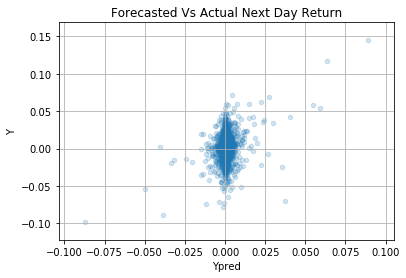

In [22]:
pred1 = pd.DataFrame(index=Xs.index)
pred1['Ypred'] = model1.predict(Xs)
pred1['Y'] = y

_ = ( pred1
     .plot(kind='scatter',x='Ypred',y='Y',grid=True,alpha=.2)
     .set(title='Forecasted Vs Actual Next Day Return')
     )

In [23]:
trade_dates_long  = pred1.loc[pred1['Ypred']>=0].index
trade_dates_short = pred1.loc[pred1['Ypred']<0].index

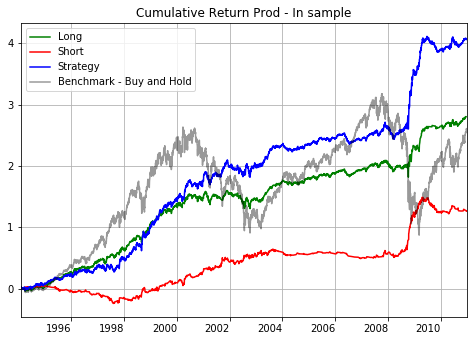

In [24]:
strategyA_daily      = data['PRet'].loc[trade_dates_long].fillna(0)-.00005
strategyAShort_daily = data['PRet'].loc[trade_dates_short].fillna(0)*-1-.00005
strategyANet_daily = strategyA_daily.append(strategyAShort_daily).sort_index()
benchmark_daily = data['PRet'].reindex(train.index)
# strategyA  = (strategyA_daily+1).cumprod()-1
# strategyAShort = (strategyAShort_daily+1).cumprod()-1 
# strategyANet = (strategyANet_daily+1).cumprod()-1
strategyA  = (strategyA_daily).cumsum()
strategyAShort = (strategyAShort_daily).cumsum() 
strategyANet = (strategyANet_daily).cumsum()
benchmark  = (benchmark_daily+1).cumprod()-1
_ =  strategyA.plot(color='g')
_ = strategyAShort.plot(color='r')
_ = strategyANet.plot(color='b')
_ =  ((benchmark
      .plot(figsize=(8,6),grid=True,rot=0,alpha=.4,color='k')
      .set(title='Cumulative Return Prod - In sample',xlabel='')))
_ = plt.legend(['Long','Short','Strategy','Benchmark - Buy and Hold'])

__Enhancement__

 - Well this stragey works atleast theoretically!
 
 Lets try to improve the forecasting model. 
 
 It is always difficult to predict the "returns"
 but we can agument the problem by not predicting 
 the returns but the relative return trend.
 
 
 Lets start by looking at the distribution plot of 
 features and target.



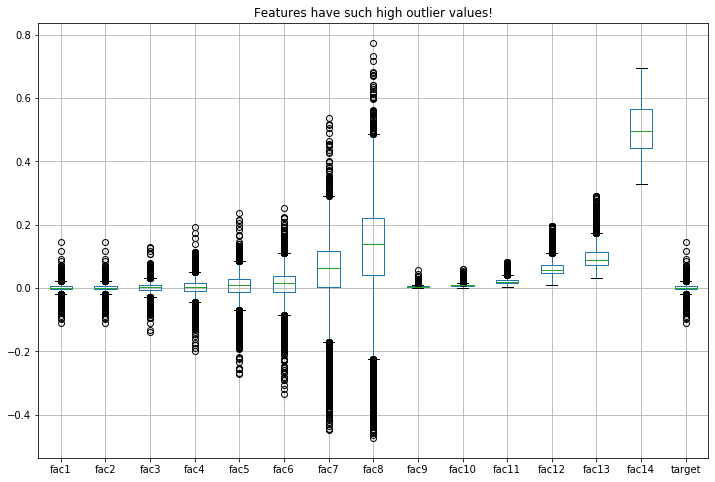

In [25]:
_ = (data[factors+['target']]
     .boxplot(figsize=(12,8))
     .set(title='Features have such high outlier values!')
    )

In [26]:
def ts_zscore(df,period=5):
    return (df - df.rolling(period).mean()) / df.rolling(period).std()

def rank(df):
    ## along the row
    return df.rank()


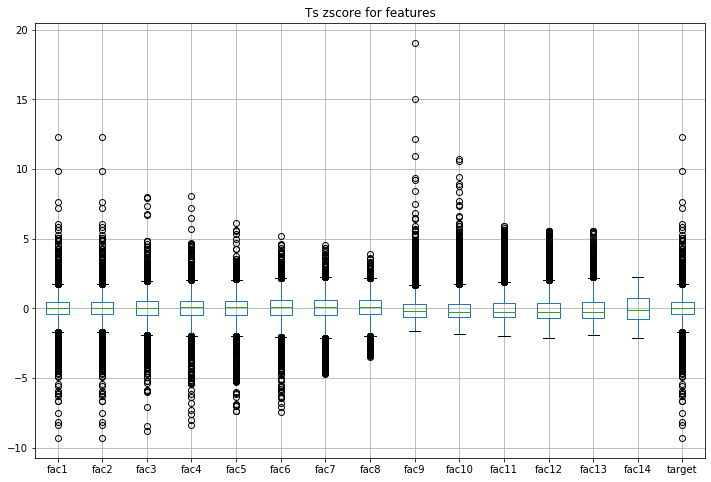

In [27]:
# Zscoring the features help!! But appears to not be working in this case?
# Why could that be?
# Trend?
_ = (data[factors+['target']]
     .pipe(zscore)
     .boxplot(figsize=(12,8))
     .set(title='Ts zscore for features')
    )

__Time Series Zscore__

Lets try to de-trend the series and think the features in relative
terms of last week returns.

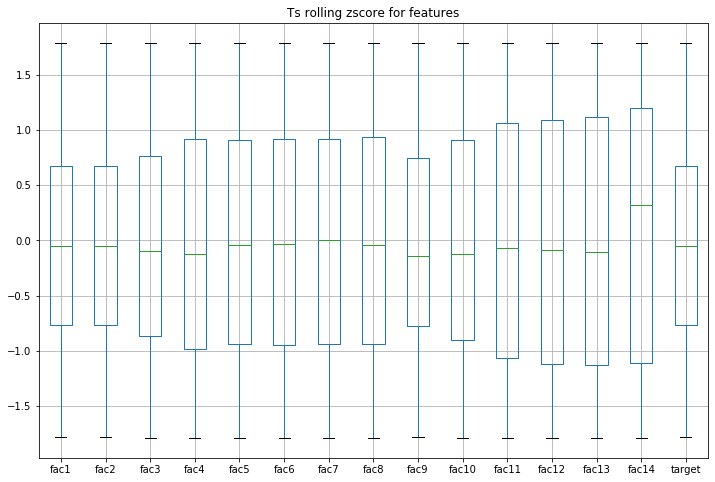

In [76]:
_ = (data[factors+['target']]
     .pipe(ts_zscore,period=5)
     .boxplot(figsize=(12,8))
     .set(title='Ts rolling zscore for features')
    )
# These features look nicely distributed.
# And are ideal for ols based methods.

In [77]:
(data[factors]
 .pipe(ts_zscore,period=5)
 .dropna()
 .corrwith(data['target']
 .pipe(ts_zscore,period=5)
 .dropna())
 .to_frame(name='Correlation b/w zscore of features and target')) 

# increased correlation with features with fac4,fac5,fac6,fac7,fac8 etc

,Correlation b/w zscore of features and target
fac1,-0.061678
fac2,-0.087231
fac3,-0.098498
fac4,-0.260441
fac5,-0.251810
fac6,-0.244180
fac7,-0.255867
fac8,-0.245577
fac9,0.113055
fac10,0.121972


In [78]:
dataP = data[factors].pipe(ts_zscore,period=5)
Y = data['target'].pipe(ts_zscore,period=5)

train = dataP.loc[:"2010"].dropna()   ; y = Y.reindex(train.index)
test_b = dataP.loc["2011":].dropna()  ; ytest_b = Y.reindex(test.index)

x = train[factors]
x = sm.add_constant(x)

model = sm.OLS(y,x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     48.19
Date:                Tue, 22 Feb 2022   Prob (F-statistic):          9.19e-125
Time:                        21:37:19   Log-Likelihood:                -5233.3
No. Observations:                4261   AIC:                         1.050e+04
Df Residuals:                    4246   BIC:                         1.059e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0342      0.013     -2.683      0.007      -0.059      -0.009
fac1           0.0178      0.039      0.458      0.647      -0.058       0.094
fac2          -0.0496      0.035     -1.405      0.160      -0.119       0.020
fac3           0.1401      0.045      3.101      0.002       0.052       0.229
fac4          -0.1150      0.016     -7.234      0.000      -0.146      -0.084
fac5          -0.0923      0.016     -5.884      0.000      -0.123      -0.062
fac6          -0.0685      0.016     -4.386      0.000      -0.099      -0.038
fac7          -0.1095      0.016     -7.036      0.000      -0.140      -0.079
fac8          -0.0935      0.015     -6.099      0.000      -0.124      -0.063
fac9           0.0250      0.021      1.175      0.240      -0.017       0.067
fac10         -0.0213      0.022     -0.984      0.325      -0.064       0.021
fac11          0.0255      0.015      1.729      0.084      -0.003       0.054
fac12          0.0124      0.014      0.893      0.372      -0.015       0.040
fac13          0.0236      0.014      1.718      0.086      -0.003       0.051
fac14         -0.0120      0.012     -1.020      0.308      -0.035       0.011
==============================================================================
Omnibus:                      147.844   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.893
Skew:                          -0.057   Prob(JB):                     1.10e-15
Kurtosis:                       2.387   Cond. No.                         10.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(2.3881529826875605, 0.056673594633982215)

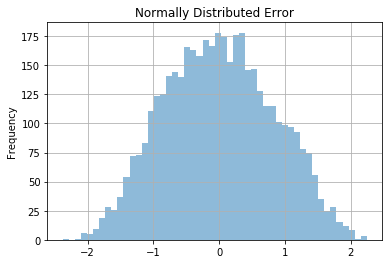

In [79]:
error = model.predict(x)-y
_ = error.plot(kind='hist',bins=50,grid=True,alpha=.5).set(title='Normally Distributed Error')
error.pipe(error_stats)

In [80]:
pred2 = pd.DataFrame()
pred2['Ypred'] =model.predict(x)
pred2['Yactual'] = y

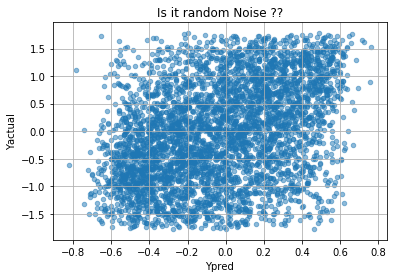

In [81]:
_ = (pred2
    .plot(kind='scatter',x='Ypred',y='Yactual',grid=True,alpha=.5)
     .set(title='Is it random Noise ??')
    )

In [82]:
# Lets enhance the model! By Adding interactionf features!

In [83]:
pf = PolynomialFeatures(degree=3)
Xp = pf.fit_transform(train[factors])

factorsp = pf.get_feature_names(factors)

Xp = pd.DataFrame(Xp,columns=factorsp,index=y.index.tolist())
y = y#.reset_index(drop=True)

In [84]:
Xp_norm1,y_norm1 = Xp.pipe(zscore).drop('1',axis=1),y.pipe(zscore)

In [85]:
mod = LassoCV(cv=20,n_jobs=4,fit_intercept=False).fit(Xp_norm1,y_norm1)

In [86]:
coefs =  pd.Series(mod.coef_,index=Xp_norm1.columns.tolist())
## Run time could be few minutes depending on processor!

In [87]:
selected_features_b = coefs[coefs!=0].index.tolist()

Xs = Xp[selected_features_b]

Xs = sm.add_constant(Xs)

In [88]:
model2 = sm.OLS(y,Xs).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     14.40
Date:                Tue, 22 Feb 2022   Prob (F-statistic):          5.76e-130
Time:                        21:38:07   Log-Likelihood:                -5142.8
No. Observations:                4261   AIC:                         1.041e+04
Df Residuals:                    4199   BIC:                         1.080e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1503      0.030     -5.025      0.000      -0.209      -0.092
fac4                 -0.0813      0.027     -3.003      0.003      -0.134      -0.028
fac5                 -0.0197      0.035     -0.561      0.575      -0.088       0.049
fac6                 -0.0554      0.024     -2.311      0.021      -0.102      -0.008
fac7                 -0.1021      0.039     -2.646      0.008      -0.178      -0.026
fac8                 -0.0069      0.039     -0.174      0.862      -0.084       0.070
fac1 fac8             0.0171      0.016      1.091      0.275      -0.014       0.048
fac1 fac10           -0.0296      0.017     -1.787      0.074      -0.062       0.003
fac1 fac12           -0.0076      0.014     -0.543      0.587      -0.035       0.020
fac2 fac13            0.0236      0.013      1.776      0.076      -0.002       0.050
fac3 fac4             0.0226      0.015      1.476      0.140      -0.007       0.053
fac4 fac11           -0.0120      0.012     -0.999      0.318      -0.036       0.012
fac5^2                0.0216      0.016      1.383      0.167      -0.009       0.052
fac5 fac14            0.0303      0.012      2.471      0.014       0.006       0.054
fac6^2                0.0353      0.015      2.290      0.022       0.005       0.065
fac6 fac13           -0.0225      0.012     -1.853      0.064      -0.046       0.001
fac7 fac9             0.0328      0.015      2.176      0.030       0.003       0.062
fac7 fac14           -0.0440      0.012     -3.574      0.000      -0.068      -0.020
fac11^2               0.0260      0.015      1.707      0.088      -0.004       0.056
fac1 fac2 fac6       -0.0157      0.020     -0.794      0.427      -0.054       0.023
fac1 fac3 fac6        0.0379      0.020      1.871      0.061      -0.002       0.078
fac1 fac3 fac7       -0.0121      0.026     -0.463      0.643      -0.063       0.039
fac1 fac5 fac11       0.0155      0.014      1.105      0.269      -0.012       0.043
fac1 fac6 fac13       0.0081      0.014      0.573      0.567      -0.020       0.036
fac1 fac9 fac10       0.0387      0.029      1.326      0.185      -0.019       0.096
fac1 fac10^2         -0.0053      0.027     -0.198      0.843      -0.057       0.047
fac1 fac11^2          0.0368      0.015      2.396      0.017       0.007       0.067
fac2 fac6 fac7        0.0187      0.016      1.157      0.248      -0.013       0.050
fac2 fac11 fac12     -0.0368      0.013     -2.931      0.003      -0.061      -0.012
fac3^2 fac7           0.0446      0.025      1.788      0.074      -0.004       0.093
fac3 fac4 fac8        0.0282      0.018      1.604      0.109      -0.006       0.063
fac3 fac6 fac8        0.0253      0.018      1.400      0.162      -0.010       0.061
fac3 fac6 fac11       0.0146      0.014      1.062      0.288      -0.012

In [89]:
arr = model2.predict(Xs)

In [90]:
trade_dates_b_buy = arr[arr>=0].index
trade_dates_b_sell = arr[arr<0].index

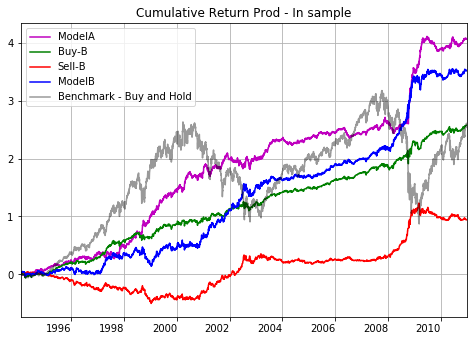

In [124]:
strategyANet.plot(color='m')
strategyB_daily = data['PRet'].loc[trade_dates_b_buy].fillna(0)-.00005 
strategyBShort_daily = data['PRet'].loc[trade_dates_b_sell].fillna(0)*(-1)-.00005 
strategyBNet_daily = strategyB_daily.append(strategyBShort_daily).sort_index()

# strategyB = (strategyB_daily+1).cumprod()-1
# strategyBShort = (strategyBShort_daily+1).cumprod()-1
# strategyBNet = (1+strategyBNet_daily).cumprod()-1

strategyB = (strategyB_daily).cumsum()
strategyBShort = (strategyBShort_daily).cumsum()
strategyBNet = strategyBNet_daily.cumsum()
benchmark  = (benchmark_daily+1).cumprod()-1

_ =  strategyB.plot(color='g')
_ =  strategyBShort.plot(color='r')
_ =  strategyBNet.plot(color='b')
_ =  (benchmark.plot(figsize=(8,6),grid=True,rot=0,alpha=.4,color='k')
      .set(title='Cumulative Return Prod - In sample',xlabel=''))
_ = plt.legend(['ModelA','Buy-B','Sell-B','ModelB','Benchmark - Buy and Hold'])

In [92]:
returns = pd.DataFrame(index=train.index)
drawdowns = pd.DataFrame(index=train.index)
returns['strategyA'] = strategyANet_daily
returns['strategyB'] = strategyBNet_daily
returns['benchmark'] = benchmark_daily

In [93]:
def sharpe(df):
    return (df.mean()/df.std())*np.sqrt(252)

def sortino(df):
    return (df.mean()/(df[df<0].std()))*np.sqrt(252)

def volatility(df):
    return df.std()*np.sqrt(252)

def running_drawdown(df):
    cumprod = (1+df).cumprod()
    return (cumprod/cumprod.expanding().max()-1)

def mean_returns(df):
    return df.mean()*252

In [94]:
performance = pd.DataFrame() 
performance['Sharpe-InSample'] = returns.pipe(sharpe)
performance['Sortino-InSample'] = returns.pipe(sortino)  
performance['Drawdown-InSample'] = returns.pipe(running_drawdown).min()
performance['Volatillty-InSample'] = returns.pipe(volatility)
performance['MeanReturn-InSample'] = returns.pipe(mean_returns)

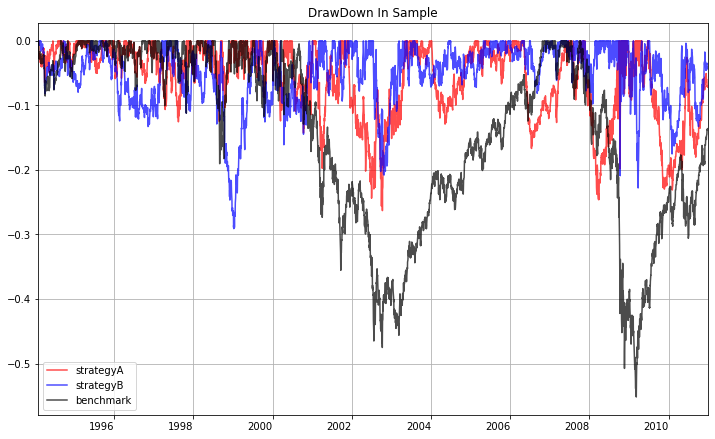

In [95]:
_ = (returns
.pipe(running_drawdown)
.plot(grid=True,alpha=.7,rot=0,figsize=(12,8),color=['r','b','k'])
.set(title='DrawDown In Sample',xlabel=''))

In [96]:
performance.T

,strategyA,strategyB,benchmark
Sharpe-InSample,1.183644,1.031058,0.469489
Sortino-InSample,1.824160,1.498698,0.623096
Drawdown-InSample,-0.263048,-0.290941,-0.551894
Volatillty-InSample,0.201859,0.202001,0.202391
MeanReturn-InSample,0.238929,0.208275,0.095020


__Out sample Performance!!__

In [97]:
Xtest_b = pf.fit_transform(test_b)
factors_test_b = pf.get_feature_names(test_b.columns.tolist())
Xtest_b = pd.DataFrame(Xtest_b,columns=factors_test_b,index=test_b.index.tolist())

In [98]:
Xtest_a = pf.fit_transform(test)
factors_test_a = pf.get_feature_names(test.columns.tolist())
Xtest_a = pd.DataFrame(Xtest_a,columns=factors_test_a,index=test.index.tolist())

In [99]:
Xtest_b = Xtest_b[selected_features_b] ## we are only going to keep features we selected during training!!
Xtest_b = sm.add_constant(Xtest_b)

In [100]:
Xtest_a = Xtest_a[selected_features_a]
Xtest_a = sm.add_constant(Xtest_a)

In [101]:
arr_test_a = model1.predict(Xtest_a)
arr_test_b = model2.predict(Xtest_b)

In [102]:
print(f"Out sample correlation of Strategy B target and forecast {arr_test_b.corr(ytest_b):.3f}.")

Out sample correlation of Strategy B target and forecast 0.349.


In [103]:
trade_dates_test_a = arr_test_a[arr_test_a>0].index
trade_dates_test_b = arr_test_b[arr_test_b>0].index

In [104]:
signalA = pd.Series(np.where(arr_test_a>=0,1,-1),index=arr_test_a.index)
strategyA_daily_test = (data['PRet'].loc[signalA.index]).mul(signalA) - 0.00005 # 5 bps cost for each day

signalB = pd.Series(np.where(arr_test_b>=0,1,-1),index=arr_test_b.index)
strategyB_daily_test = (data['PRet'].loc[signalB.index]).mul(signalB) - 0.00005 # 5 bps cost for each day

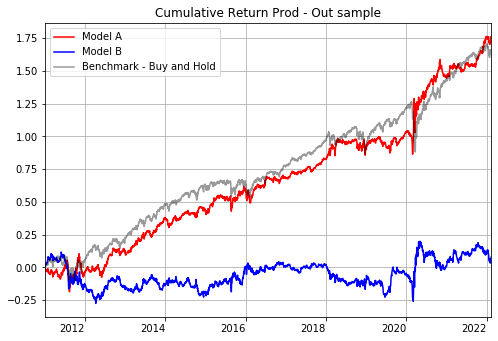

In [105]:
# strategyA_test = (strategyA_daily_test+1).cumprod()-1
# strategyB_test = (strategyB_daily_test+1).cumprod()-1

benchmark_daily_test = data['PRet'].reindex(strategyB_daily_test.index)

strategyA_test = strategyA_daily_test.cumsum()
strategyB_test = strategyB_daily_test.cumsum()
benchmark_test = benchmark_daily_test.cumsum()
_ =  strategyA_test.plot(color='r')
_ =  strategyB_test.plot(color='b')
_ =  ((benchmark_test
      .plot(figsize=(8,6),grid=True,rot=0,alpha=.4,color='k')
      .set(title='Cumulative Return Prod - Out sample',xlabel='')))
_ = plt.legend(['Model A','Model B','Benchmark - Buy and Hold'])

In [106]:
returns_test = pd.DataFrame(index=benchmark_test.index)
drawdowns_test = pd.DataFrame(index=benchmark_test.index)
returns_test['strategyA'] = strategyA_daily_test
returns_test['strategyB'] = strategyB_daily_test
returns_test['benchmark'] = benchmark_daily_test

In [107]:
performance['Sharpe-OutSample'] = returns_test.pipe(sharpe)
performance['Sortino-OutSample'] = returns_test.pipe(sortino)  
performance['Drawdown-OutSample'] = returns_test.pipe(running_drawdown).min()
performance['Volatillty-OutSample'] = returns_test.pipe(volatility)
performance['MeanReturn-OutSample'] = returns_test.pipe(mean_returns)

In [108]:
performance.T.sort_index()

,strategyA,strategyB,benchmark
Drawdown-InSample,-0.263048,-0.290941,-0.551894
Drawdown-OutSample,-0.236462,-0.375479,-0.337173
MeanReturn-InSample,0.238929,0.208275,0.095020
MeanReturn-OutSample,0.155239,0.007185,0.146381
Sharpe-InSample,1.183644,1.031058,0.469489
Sharpe-OutSample,0.919576,0.042480,0.866697
Sortino-InSample,1.824160,1.498698,0.623096
Sortino-OutSample,1.216458,0.056597,1.020046
Volatillty-InSample,0.201859,0.202001,0.202391
Volatillty-OutSample,0.168816,0.169142,0.168895


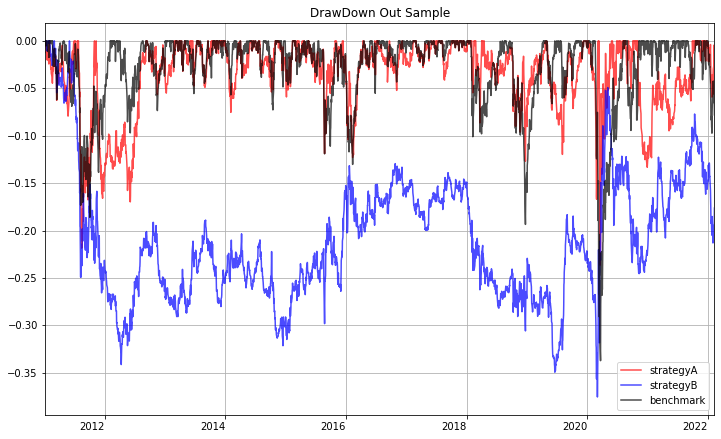

In [109]:
_ = (returns_test
.pipe(running_drawdown)
.plot(grid=True,alpha=.7,rot=0,figsize=(12,8),color=['r','b','k'])
.set(title='DrawDown Out Sample',xlabel=''))

In [110]:
# A terrible out sample performance!! There seems to be a big regime change!
# lets check for rolling performance!!


In [111]:
print(f"Years of data available {data.index.year.drop_duplicates().tolist()}")
# Lets train for trailing "n" year at a time and test on next 1 year

Years of data available [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [112]:
benchmark = pd.Series()
strategy  = pd.Series()
for test_year in range(2015,2022):
    print(test_year)
    train_data = data.loc[f'{test_year-11}':f'{test_year-1}',factors+['target']].dropna()
    test_data = data.loc[f'{test_year}',factors+['target']].dropna()
    
    X_train , y_train = train_data[factors] , train_data['target']
    X_test  , y_test  = test_data[factors]  , test_data['target']
    
    # Lasso Feature Selection!! 
    
    pf_ = PolynomialFeatures(degree=2,include_bias=False)
    X_train_ = pf_.fit_transform(X_train)    
    factors_name = pf_.get_feature_names(X_train.columns.tolist())

    X_train = pd.DataFrame(X_train_,columns=factors_name,index=X_train.index.tolist())

    X_train_norm = X_train.pipe(zscore); y_train_norm = y_train.pipe(zscore)
    mod_ = LassoCV(cv=10,n_jobs=4,fit_intercept=False,selection='random').fit(X_train_norm,y_train_norm)
    coefs_ =  pd.Series(mod_.coef_,index=X_train_norm.columns.tolist())
    selected_features = coefs_[coefs_!=0].index.tolist()
        
    x_train = X_train[selected_features]
    x_train = sm.add_constant(x_train)
    model_  = sm.OLS(y_train,x_train).fit()
    
    X_test = pd.DataFrame(pf_.transform(X_test),columns=factors_name,index=X_test.index.tolist())
    X_test = X_test[selected_features]
    X_test = sm.add_constant(X_test)
    y_predicted = model_.predict(X_test)
    
    signal = pd.Series(np.where(y_predicted>=0,1,-1),index=y_predicted.index)
    strategy_return = (y_test.loc[signal.index]).mul(signal) # 5 bps cost for each day

    strategy  = strategy.append(strategy_return)
    benchmark = benchmark.append(y_test)

2015
2016
2017
2018
2019
2020
2021


In [113]:
performance_ = pd.DataFrame()
returns_     = pd.DataFrame()
returns_['benchmark'] = benchmark
returns_['strategy']  = strategy - .00005

performance_['Sharpe-OutSample'] = returns_.pipe(sharpe)
performance_['Sortino-OutSample'] = returns_.pipe(sortino)  
performance_['Drawdown-OutSample'] = returns_.pipe(running_drawdown).min()
performance_['Volatillty-OutSample'] = returns_.pipe(volatility)
performance_['MeanReturn-OutSample'] = returns_.pipe(mean_returns)

performance_

,Sharpe-OutSample,Sortino-OutSample,Drawdown-OutSample,Volatillty-OutSample,MeanReturn-OutSample
benchmark,0.871975,0.998436,-0.337173,0.176695,0.154073
strategy,0.879091,1.159246,-0.233899,0.176645,0.155287


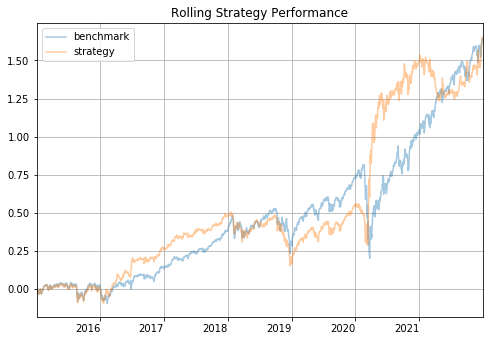

In [114]:
_ = (((1+returns_)
  .cumprod()-1)
 .plot(grid=True,alpha=.4,rot=0,figsize=(8,6))
 .set(title="Rolling Strategy Performance")
)

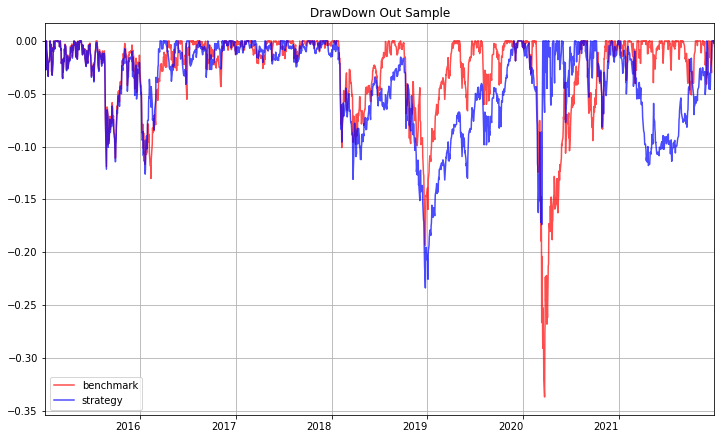

In [115]:
_ = (returns_
.pipe(running_drawdown)
.plot(grid=True,alpha=.7,rot=0,figsize=(12,8),color=['r','b','k'])
.set(title='DrawDown Out Sample',xlabel=''))

In [116]:
benchmark = pd.Series()
strategy  = pd.Series()
dataNormalize = data[factors+['target']].pipe(ts_zscore)
for test_year in range(2015,2022):
    print(test_year)
    train_data = dataNormalize.loc[f'{test_year-11}':f'{test_year-1}',factors+['target']].dropna()
    test_data = dataNormalize.loc[f'{test_year}',factors+['target']].dropna()
    
    X_train , y_train = train_data[factors] , train_data['target']
    X_test  , y_test  = test_data[factors]  , test_data['target']
    y_test_return = data['PRet'].loc[y_test.index] 
    
    # Lasso Feature Selection!! 
    
    pf_ = PolynomialFeatures(degree=2,include_bias=False)
    X_train_ = pf_.fit_transform(X_train)    
    factors_name = pf_.get_feature_names(X_train.columns.tolist())

    X_train = pd.DataFrame(X_train_,columns=factors_name,index=X_train.index.tolist())

    X_train_norm = X_train.pipe(zscore); y_train_norm = y_train.pipe(zscore)
    mod_ = LassoCV(cv=10,n_jobs=4,fit_intercept=False,selection='random').fit(X_train_norm,y_train_norm)
    coefs_ =  pd.Series(mod_.coef_,index=X_train_norm.columns.tolist())
    selected_features = coefs_[coefs_!=0].index.tolist()
        
    x_train = X_train[selected_features]
    x_train = sm.add_constant(x_train)
    model_  = sm.OLS(y_train,x_train).fit()
    
    X_test = pd.DataFrame(pf_.transform(X_test),columns=factors_name,index=X_test.index.tolist())
    X_test = X_test[selected_features]
    X_test = sm.add_constant(X_test)
    y_predicted = model_.predict(X_test)
    
    signal = pd.Series(np.where(y_predicted>=0,1,-1),index=y_predicted.index)
    strategy_return = (y_test_return.loc[signal.index]).mul(signal) # 5 bps cost for each day

    strategy  = strategy.append(strategy_return)
    benchmark = benchmark.append(y_test_return)

2015
2016
2017
2018
2019
2020
2021


In [117]:
performance_ = pd.DataFrame()
returns_     = pd.DataFrame()
returns_['benchmark'] = benchmark
returns_['strategy']  = strategy - .00005

performance_['Sharpe-OutSample'] = returns_.pipe(sharpe)
performance_['Sortino-OutSample'] = returns_.pipe(sortino)  
performance_['Drawdown-OutSample'] = returns_.pipe(running_drawdown).min()
performance_['Volatillty-OutSample'] = returns_.pipe(volatility)
performance_['MeanReturn-OutSample'] = returns_.pipe(mean_returns)

performance_

,Sharpe-OutSample,Sortino-OutSample,Drawdown-OutSample,Volatillty-OutSample,MeanReturn-OutSample
benchmark,0.871975,0.998436,-0.337173,0.176695,0.154073
strategy,0.280766,0.373103,-0.333325,0.176918,0.049672


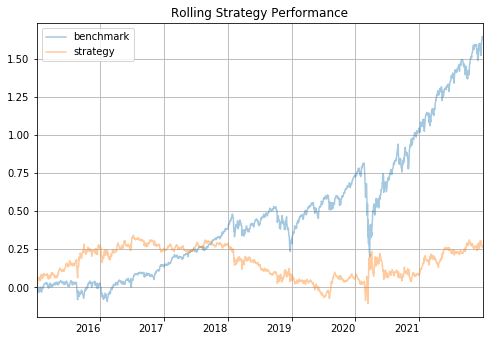

In [118]:
_ = (((1+returns_)
  .cumprod()-1)
 .plot(grid=True,alpha=.4,rot=0,figsize=(8,6))
 .set(title="Rolling Strategy Performance")
)

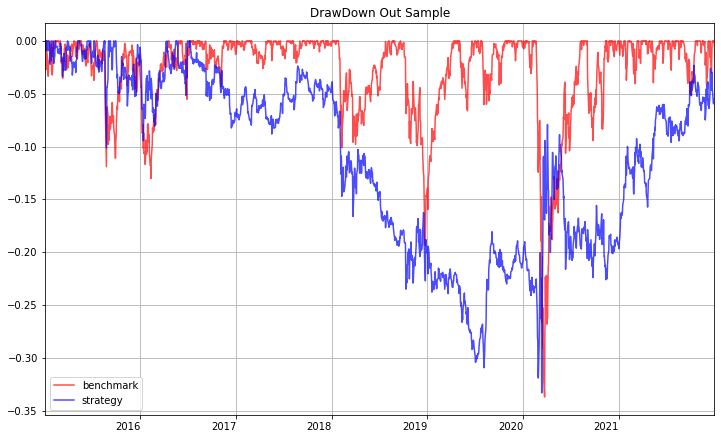

In [119]:
_ = (returns_
.pipe(running_drawdown)
.plot(grid=True,alpha=.7,rot=0,figsize=(12,8),color=['r','b','k'])
.set(title='DrawDown Out Sample',xlabel=''))

## Random Strategy!!

- assuming daily sign reversal

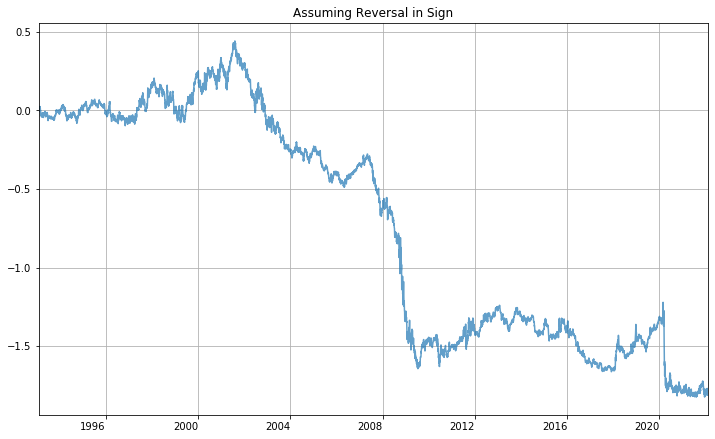

In [122]:
random = np.where(data['PRet'].shift()>=0,data['PRet'],data['PRet']*-1)

random = pd.Series(random,index=data.index)

_ = (((random).cumsum())
     .plot(grid=True,alpha=.7,rot=0,figsize=(12,8))
     .set(title='Assuming Reversal in Sign',xlabel=''))

## Take Aways!!

1. We looked at basics of feature engineering. Price Related return or even alternative factors sometime add values
  even in most generic definition.
2. How to leverage "lasso based" shrinkage to add non-linearity of ols based method.
3. An improved model may or maynot direclty transalte to higher alpha ? Requires more sophisticated strategy.
4. A walk forwad based trading strategy is also a good idea to test for strategy stability over the long period.